<a href="https://colab.research.google.com/github/Ibrahimsyah/Foories/blob/master/notebooks/04_Transfer_Learning_TFLITE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown -q

In [ ]:
import pathlib
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm

In [ ]:
print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.4.1
• Using TensorFlow Hub Version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Found.


In [ ]:
!gdown 'https://drive.google.com/uc?id=1xGVpcGWblW2xc8WR7LBi5s4rqfNdwQYr' -O dataset_cleaned_v2.zip

Downloading...
From: https://drive.google.com/uc?id=1xGVpcGWblW2xc8WR7LBi5s4rqfNdwQYr
To: /content/dataset_cleaned_v2.zip
170MB [00:05, 30.3MB/s]


In [ ]:
!unzip -q dataset_cleaned_v2.zip
!mv /content/content/dataset /content
!rm -rf /content/content

In [ ]:
!ls /content/dataset/train

bakso  dessert	french_fries  hamburger  nasirendang  sate  soup       sushi
bread  egg	fried_rice    meat	 pizza	      soto  spaghetti  vegfruit


In [ ]:
dataset_dir = "/content/dataset"
train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/dev"
test_dir = "/content/dataset/test"

In [ ]:
class_names = ['bakso', 'bread', 'french_fries', 'hamburger', 'nasirendang',
               'sate', 'soup', 'sushi', 'bread', 'egg', 'fried_rice', 'meat',
               'pizza', 'soto', 'spaghetti', 'vegfruit']

In [ ]:
# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [ ]:
module_selection

('mobilenet_v2', 224, 1280)

In [ ]:
BATCH_SIZE = 64 #@param {type:"integer"}

In [ ]:
do_fine_tuning = False #@param {type:"boolean"}

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [ ]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(16, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 16)                20496     
Total params: 2,278,480
Trainable params: 20,496
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

In [ ]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# Training datagen
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen =  ImageDataGenerator(rescale=1./255)

# Flow training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

# Flow validation data generator
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

# Flow test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

Found 11372 images belonging to 16 classes.
Found 2000 images belonging to 16 classes.
Found 2000 images belonging to 16 classes.


##MobileNet_v2

In [ ]:
EPOCHS = 10

hist2 = model.fit(train_generator,
                epochs=EPOCHS,
                validation_data=validation_generator)

Epoch 1/10
178/178 [==============================] - 116s 620ms/step - loss: 1.7599 - accuracy: 0.4677 - val_loss: 0.8205 - val_accuracy: 0.7485
Epoch 2/10
178/178 [==============================] - 110s 620ms/step - loss: 0.8036 - accuracy: 0.7523 - val_loss: 0.7669 - val_accuracy: 0.7585
Epoch 3/10
178/178 [==============================] - 110s 620ms/step - loss: 0.7026 - accuracy: 0.7809 - val_loss: 0.6955 - val_accuracy: 0.7875
Epoch 4/10
178/178 [==============================] - 110s 619ms/step - loss: 0.6321 - accuracy: 0.8031 - val_loss: 0.6760 - val_accuracy: 0.7900
Epoch 5/10
178/178 [==============================] - 110s 618ms/step - loss: 0.5872 - accuracy: 0.8185 - val_loss: 0.6564 - val_accuracy: 0.7935
Epoch 6/10
178/178 [==============================] - 110s 618ms/step - loss: 0.5750 - accuracy: 0.8203 - val_loss: 0.6580 - val_accuracy: 0.7885
Epoch 7/10
178/178 [==============================] - 110s 618ms/step - loss: 0.5356 - accuracy: 0.8327 - val_loss: 0.6429 -

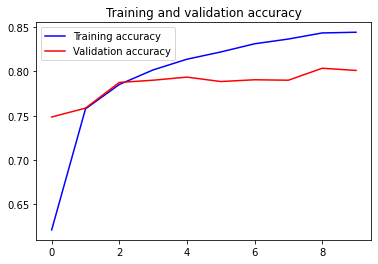

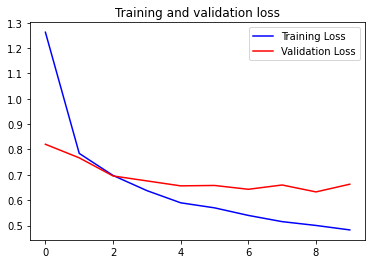

In [ ]:
import matplotlib.pyplot as plt
acc = hist2.history['accuracy']
val_acc = hist2.history['val_accuracy']
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate on Testing data
scores = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("test acc: ", model.metrics_names[1], scores[1]*100))

32/32 [==============================] - 4s 116ms/step - loss: 0.6114 - accuracy: 0.8155
test acc: accuracy: 81.55%


Conclusion:

Transfer Learning Mobilenet_v2
- Training: 84,34%
- Validation: 80,10%
- Testing: 81,55%

In [ ]:
model.save('model.h5')

##Exporting to TFLite

In [ ]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [ ]:
#@title Select mode of optimization
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

2647632

In [ ]:
try:
    from google.colab import files
    
    files.download(tflite_model_file)
    files.download('labels.txt')
    files.download('model.h5')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>